<a href="https://colab.research.google.com/github/Varsha-R/Deep-Learning/blob/main/Intro_to_DL_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Common functions

In [2]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 12.1 MB/s 
     |████████████████████████████████| 13.7 MB 194 kB/s 
     |████████████████████████████████| 120 kB 13.2 MB/s 
     |████████████████████████████████| 1.9 MB 16.7 MB/s 


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, NesterovMomentumOptimizer
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [ ]:
def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [ ]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [ ]:
dev = qml.device("default.qubit", wires=4)

In [ ]:
irisData = datasets.load_iris()
X = irisData.data[:100]
print("First X sample (original)  :", X[0])

# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Y = irisData.target[:100]
# Changing labels from 0,1 to 1, -1
for index, val in enumerate(Y):
  if val == 0:
    Y[index] = -1
  else:
    Y[index] = 1
    
print("First Y class (original)  :", Y[0])

First X sample (original)  : [5.1 3.5 1.4 0.2]
First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]
First features sample      : [ 0.44954297 -0.14189705  0.14189705 -0.60145471  0.60145471]
First Y class (original)  : -1


In [ ]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [ ]:
num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
epochs = 60
epochsList = []
for i in range(1, epochs + 1):
  epochsList.append(i)

In [ ]:
opt = AdamOptimizer(0.1)
batch_size = 5

In [ ]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

# Original - amplitude embedding

In [ ]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [ ]:
# train the variational classifier
weights = weights_init
bias = bias_init

amplitudeEmbeddingCost = []
amplitudeEmbeddingTrainAccuracy = []
amplitudeEmbeddingValAccuracy = []

for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    circuit_cost = cost(weights, bias, features, Y)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, circuit_cost, acc_train, acc_val)
    )
    amplitudeEmbeddingCost.append(circuit_cost)
    amplitudeEmbeddingTrainAccuracy.append(acc_train)
    amplitudeEmbeddingValAccuracy.append(acc_val)

Iter:     1 | Cost: 0.8673621 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 0.6839394 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     3 | Cost: 0.6649874 | Acc train: 0.9733333 | Acc validation: 0.9600000 
Iter:     4 | Cost: 0.7158160 | Acc train: 0.6000000 | Acc validation: 0.7200000 
Iter:     5 | Cost: 0.7162785 | Acc train: 0.5600000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 0.6843303 | Acc train: 0.6133333 | Acc validation: 0.6800000 
Iter:     7 | Cost: 0.6696642 | Acc train: 0.6266667 | Acc validation: 0.6800000 
Iter:     8 | Cost: 0.6094623 | Acc train: 0.9066667 | Acc validation: 0.8400000 
Iter:     9 | Cost: 0.5817037 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    10 | Cost: 0.6176762 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    11 | Cost: 0.6176803 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    12 | Cost: 0.6022390 | Acc train: 0.9333333 | Acc validation: 0.9200000 
Iter:    13 | Co

In [ ]:
print("Cost: ", amplitudeEmbeddingCost)
print("Training accuracy: ", amplitudeEmbeddingTrainAccuracy)
print("Validation accuracy: ", amplitudeEmbeddingValAccuracy)

Cost:  [tensor(0.86736209, requires_grad=True), tensor(0.6839394, requires_grad=True), tensor(0.6649874, requires_grad=True), tensor(0.71581596, requires_grad=True), tensor(0.71627847, requires_grad=True), tensor(0.6843303, requires_grad=True), tensor(0.66966421, requires_grad=True), tensor(0.60946231, requires_grad=True), tensor(0.5817037, requires_grad=True), tensor(0.61767619, requires_grad=True), tensor(0.61768026, requires_grad=True), tensor(0.60223895, requires_grad=True), tensor(0.64155333, requires_grad=True), tensor(0.60668192, requires_grad=True), tensor(0.55258284, requires_grad=True), tensor(0.58843005, requires_grad=True), tensor(0.70572068, requires_grad=True), tensor(0.52832846, requires_grad=True), tensor(0.48402397, requires_grad=True), tensor(0.54458438, requires_grad=True), tensor(0.64918097, requires_grad=True), tensor(0.60624957, requires_grad=True), tensor(0.56460378, requires_grad=True), tensor(0.59685289, requires_grad=True), tensor(0.60660896, requires_grad=Tru

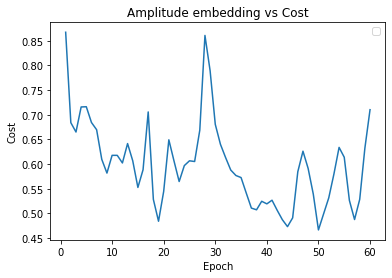

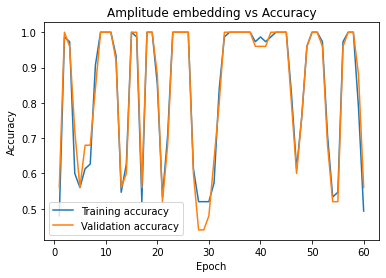

In [ ]:
plt.title("Amplitude embedding vs Cost")
plt.plot(epochsList, amplitudeEmbeddingCost)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print()

plt.title("Amplitude embedding vs Accuracy")
plt.plot(epochsList, amplitudeEmbeddingTrainAccuracy, label = "Training accuracy")
plt.plot(epochsList, amplitudeEmbeddingValAccuracy, label = "Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Rotational encoding - Rx

In [ ]:
def statepreparation(a):
    for i in range(4):
      qml.RX(a[i], wires=i)

In [ ]:
# train the variational classifier
weights = weights_init
bias = bias_init

rXEmbeddingCost = []
rXEmbeddingTrainAccuracy = []
rXEmbeddingValAccuracy = []

for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    circuit_cost = cost(weights, bias, features, Y)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, circuit_cost, acc_train, acc_val)
    )
    rXEmbeddingCost.append(circuit_cost)
    rXEmbeddingTrainAccuracy.append(acc_train)
    rXEmbeddingValAccuracy.append(acc_val)

Iter:     1 | Cost: 1.8903964 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.8110739 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.7013542 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.5370092 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.3552491 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.1756925 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.1003697 | Acc train: 0.1066667 | Acc validation: 0.0800000 
Iter:     8 | Cost: 1.0847707 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     9 | Cost: 1.0451071 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    10 | Cost: 1.0501114 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    11 | Cost: 1.0078593 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    12 | Cost: 0.9342774 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    13 | Co

In [ ]:
print("Cost: ", rXEmbeddingCost)
print("Cost: ", rXEmbeddingTrainAccuracy)
print("Cost: ", rXEmbeddingValAccuracy)

Cost:  [tensor(1.89039639, requires_grad=True), tensor(1.81107387, requires_grad=True), tensor(1.70135424, requires_grad=True), tensor(1.53700925, requires_grad=True), tensor(1.35524906, requires_grad=True), tensor(1.17569248, requires_grad=True), tensor(1.10036973, requires_grad=True), tensor(1.08477073, requires_grad=True), tensor(1.04510708, requires_grad=True), tensor(1.05011142, requires_grad=True), tensor(1.00785932, requires_grad=True), tensor(0.93427744, requires_grad=True), tensor(0.87855545, requires_grad=True), tensor(0.79716, requires_grad=True), tensor(0.7347006, requires_grad=True), tensor(0.70608699, requires_grad=True), tensor(0.6886764, requires_grad=True), tensor(0.66990732, requires_grad=True), tensor(0.65859831, requires_grad=True), tensor(0.62745012, requires_grad=True), tensor(0.59946329, requires_grad=True), tensor(0.58006555, requires_grad=True), tensor(0.62095544, requires_grad=True), tensor(0.66523885, requires_grad=True), tensor(0.63350428, requires_grad=True

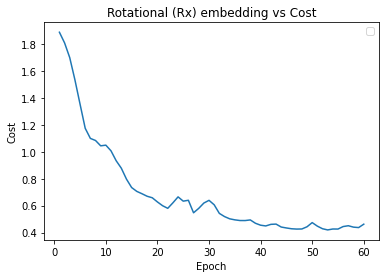

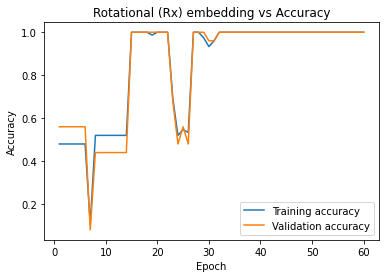

In [ ]:
plt.title("Rotational (Rx) embedding vs Cost")
plt.plot(epochsList, rXEmbeddingCost)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print()

plt.title("Rotational (Rx) embedding vs Accuracy")
plt.plot(epochsList, rXEmbeddingTrainAccuracy, label = "Training accuracy")
plt.plot(epochsList, rXEmbeddingValAccuracy, label = "Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Rotational encoding - Ry

In [ ]:
def statepreparation(a):
    for i in range(4):
      qml.RY(a[i], wires=i)

In [ ]:
# train the variational classifier
weights = weights_init
bias = bias_init

rYEmbeddingCost = []
rYEmbeddingTrainAccuracy = []
rYEmbeddingValAccuracy = []

for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    circuit_cost = cost(weights, bias, features, Y)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, circuit_cost, acc_train, acc_val)
    )
    rYEmbeddingCost.append(circuit_cost)
    rYEmbeddingTrainAccuracy.append(acc_train)
    rYEmbeddingValAccuracy.append(acc_val)

Iter:     1 | Cost: 1.8197723 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.6824156 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.4619985 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.2124672 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.1264314 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.0568290 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.0570529 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.0599191 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.0544655 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 1.1154493 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.1370076 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    12 | Cost: 1.1495446 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    13 | Co

In [ ]:
print("Cost: ", rYEmbeddingCost)
print("Cost: ", rYEmbeddingTrainAccuracy)
print("Cost: ", rYEmbeddingValAccuracy)

Cost:  [tensor(1.81977228, requires_grad=True), tensor(1.68241555, requires_grad=True), tensor(1.46199851, requires_grad=True), tensor(1.21246716, requires_grad=True), tensor(1.12643144, requires_grad=True), tensor(1.05682905, requires_grad=True), tensor(1.05705288, requires_grad=True), tensor(1.05991906, requires_grad=True), tensor(1.05446548, requires_grad=True), tensor(1.11544929, requires_grad=True), tensor(1.13700761, requires_grad=True), tensor(1.14954455, requires_grad=True), tensor(1.11097486, requires_grad=True), tensor(0.99990977, requires_grad=True), tensor(0.86378321, requires_grad=True), tensor(0.72737205, requires_grad=True), tensor(0.64943047, requires_grad=True), tensor(0.61668739, requires_grad=True), tensor(0.68560444, requires_grad=True), tensor(0.83303596, requires_grad=True), tensor(0.81874047, requires_grad=True), tensor(0.70810316, requires_grad=True), tensor(0.67889615, requires_grad=True), tensor(0.64738848, requires_grad=True), tensor(0.64915998, requires_grad

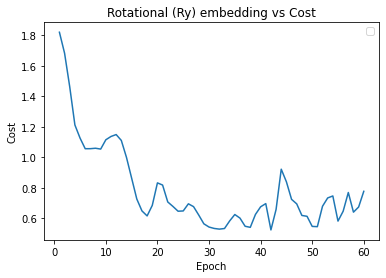

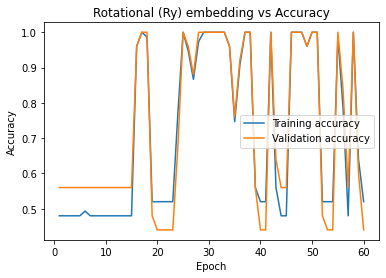

In [ ]:
plt.title("Rotational (Ry) embedding vs Cost")
plt.plot(epochsList, rYEmbeddingCost)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print()

plt.title("Rotational (Ry) embedding vs Accuracy")
plt.plot(epochsList, rYEmbeddingTrainAccuracy, label = "Training accuracy")
plt.plot(epochsList, rYEmbeddingValAccuracy, label = "Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Rotational encoding - Rz

In [ ]:
def statepreparation(a):
    for i in range(4):
      qml.RZ(a[i], wires=i)

In [ ]:
# train the variational classifier
weights = weights_init
bias = bias_init

rZEmbeddingCost = []
rZEmbeddingTrainAccuracy = []
rZEmbeddingValAccuracy = []

for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    circuit_cost = cost(weights, bias, features, Y)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, circuit_cost, acc_train, acc_val)
    )
    rZEmbeddingCost.append(circuit_cost)
    rZEmbeddingTrainAccuracy.append(acc_train)
    rZEmbeddingValAccuracy.append(acc_val)

Iter:     1 | Cost: 1.9372696 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.8443585 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.7247120 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.5820119 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.3828947 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.1954909 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.0434256 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.0005270 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     9 | Cost: 1.0702437 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    10 | Cost: 1.2860094 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    11 | Cost: 1.5024635 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    12 | Cost: 1.4871782 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    13 | Co

In [ ]:
print("Cost: ", rZEmbeddingCost)
print("Cost: ", rZEmbeddingTrainAccuracy)
print("Cost: ", rZEmbeddingValAccuracy)

Cost:  [tensor(1.93726958, requires_grad=True), tensor(1.84435847, requires_grad=True), tensor(1.72471198, requires_grad=True), tensor(1.58201189, requires_grad=True), tensor(1.38289467, requires_grad=True), tensor(1.19549085, requires_grad=True), tensor(1.04342558, requires_grad=True), tensor(1.00052701, requires_grad=True), tensor(1.07024373, requires_grad=True), tensor(1.28600941, requires_grad=True), tensor(1.50246347, requires_grad=True), tensor(1.48717824, requires_grad=True), tensor(1.44131071, requires_grad=True), tensor(1.46808544, requires_grad=True), tensor(1.31295289, requires_grad=True), tensor(1.08972805, requires_grad=True), tensor(1.00420415, requires_grad=True), tensor(1.00619394, requires_grad=True), tensor(1.01690343, requires_grad=True), tensor(1.01469176, requires_grad=True), tensor(1.0025782, requires_grad=True), tensor(1.000026, requires_grad=True), tensor(1.00503761, requires_grad=True), tensor(1.01796623, requires_grad=True), tensor(1.03505499, requires_grad=Tr

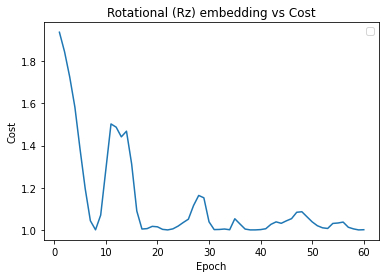

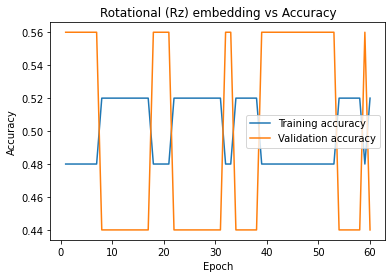

In [ ]:
plt.title("Rotational (Rz) embedding vs Cost")
plt.plot(epochsList, rZEmbeddingCost)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print()

plt.title("Rotational (Rz) embedding vs Accuracy")
plt.plot(epochsList, rZEmbeddingTrainAccuracy, label = "Training accuracy")
plt.plot(epochsList, rZEmbeddingValAccuracy, label = "Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Final graphs for this section

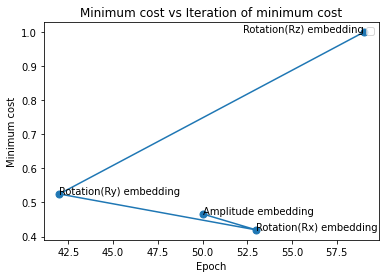

In [ ]:
firstCostGraphEpoch = []
firstCostGraphValue = []

epochAmplitudeIndex = 0
for index, tensorVal in enumerate(amplitudeEmbeddingCost):
  if tensorVal == min(amplitudeEmbeddingCost):
    epochAmplitudeIndex = index + 1
    break
firstCostGraphEpoch.append(epochAmplitudeIndex)
firstCostGraphValue.append(min(amplitudeEmbeddingCost))

epochRxIndex = 0
for index, tensorVal in enumerate(rXEmbeddingCost):
  if tensorVal == min(rXEmbeddingCost):
    epochRxIndex = index + 1
    break
firstCostGraphEpoch.append(epochRxIndex)
firstCostGraphValue.append(min(rXEmbeddingCost))

epochRyIndex = 0
for index, tensorVal in enumerate(rYEmbeddingCost):
  if tensorVal == min(rYEmbeddingCost):
    epochRyIndex = index + 1
    break
firstCostGraphEpoch.append(epochRyIndex)
firstCostGraphValue.append(min(rYEmbeddingCost))

epochRzIndex = 0
for index, tensorVal in enumerate(rZEmbeddingCost):
  if tensorVal == min(rZEmbeddingCost):
    epochRzIndex = index + 1
    break
firstCostGraphEpoch.append(epochRzIndex)
firstCostGraphValue.append(min(rZEmbeddingCost))

# print(firstCostGraphEpoch, firstCostGraphValue)

plt.title('Minimum cost vs Iteration of minimum cost')
plt.plot(firstCostGraphEpoch, firstCostGraphValue, marker='.', markersize=14)
plt.ylabel('Minimum cost')
plt.xlabel('Epoch')
plt.text(firstCostGraphEpoch[0],firstCostGraphValue[0],'Amplitude embedding')
plt.text(firstCostGraphEpoch[1],firstCostGraphValue[1],'Rotation(Rx) embedding')
plt.text(firstCostGraphEpoch[2],firstCostGraphValue[2],'Rotation(Ry) embedding')
plt.text(firstCostGraphEpoch[3],firstCostGraphValue[3],'Rotation(Rz) embedding',horizontalalignment='right')
plt.legend()
plt.show()

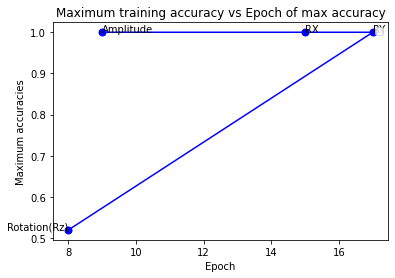

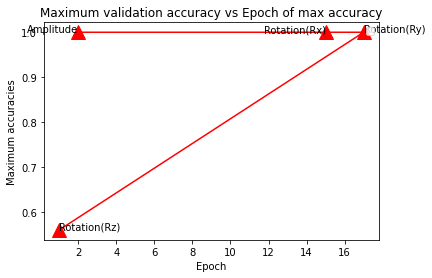

In [ ]:
firstTrainingGraphEpoch = []
firstTrainingGraphValue = []
firstValGraphEpoch = []
firstValGraphValue = []

# Amplitude
epochAmplitudeIndex = 0
for index, tensorVal in enumerate(amplitudeEmbeddingTrainAccuracy):
  if tensorVal == max(amplitudeEmbeddingTrainAccuracy):
    epochAmplitudeIndex = index + 1
    break
firstTrainingGraphEpoch.append(epochAmplitudeIndex)
firstTrainingGraphValue.append(max(amplitudeEmbeddingTrainAccuracy))

epochAmplitudeIndex = 0
for index, tensorVal in enumerate(amplitudeEmbeddingValAccuracy):
  if tensorVal == max(amplitudeEmbeddingValAccuracy):
    epochAmplitudeIndex = index + 1
    break
firstValGraphEpoch.append(epochAmplitudeIndex)
firstValGraphValue.append(max(amplitudeEmbeddingValAccuracy))

# RX
epochRxIndex = 0
for index, tensorVal in enumerate(rXEmbeddingTrainAccuracy):
  if tensorVal == max(rXEmbeddingTrainAccuracy):
    epochRxIndex = index + 1
    break
firstTrainingGraphEpoch.append(epochRxIndex)
firstTrainingGraphValue.append(max(rXEmbeddingTrainAccuracy))

epochRxIndex = 0
for index, tensorVal in enumerate(rXEmbeddingValAccuracy):
  if tensorVal == max(rXEmbeddingValAccuracy):
    epochRxIndex = index + 1
    break
firstValGraphEpoch.append(epochRxIndex)
firstValGraphValue.append(max(rXEmbeddingValAccuracy))

# RY
epochRyIndex = 0
for index, tensorVal in enumerate(rYEmbeddingTrainAccuracy):
  if tensorVal == max(rYEmbeddingTrainAccuracy):
    epochRyIndex = index + 1
    break
firstTrainingGraphEpoch.append(epochRyIndex)
firstTrainingGraphValue.append(max(rYEmbeddingTrainAccuracy))

epochRyIndex = 0
for index, tensorVal in enumerate(rYEmbeddingValAccuracy):
  if tensorVal == max(rYEmbeddingValAccuracy):
    epochRyIndex = index + 1
    break
firstValGraphEpoch.append(epochRyIndex)
firstValGraphValue.append(max(rYEmbeddingValAccuracy))

# RZ
epochRzIndex = 0
for index, tensorVal in enumerate(rZEmbeddingTrainAccuracy):
  if tensorVal == max(rZEmbeddingTrainAccuracy):
    epochRzIndex = index + 1
    break
firstTrainingGraphEpoch.append(epochRzIndex)
firstTrainingGraphValue.append(max(rZEmbeddingTrainAccuracy))

epochRzIndex = 0
for index, tensorVal in enumerate(rZEmbeddingValAccuracy):
  if tensorVal == max(rZEmbeddingValAccuracy):
    epochRzIndex = index + 1
    break
firstValGraphEpoch.append(epochRzIndex)
firstValGraphValue.append(max(rZEmbeddingValAccuracy))

# print(firstTrainingGraphEpoch, firstTrainingGraphValue)
# print(firstValGraphEpoch, firstValGraphValue)

plt.title('Maximum training accuracy vs Epoch of max accuracy')
plt.plot(firstTrainingGraphEpoch, firstTrainingGraphValue, c='b', marker='.', markersize=14)
plt.ylabel('Maximum accuracies')
plt.xlabel('Epoch')
plt.text(firstTrainingGraphEpoch[0],firstTrainingGraphValue[0],'Amplitude')
plt.text(firstTrainingGraphEpoch[1],firstTrainingGraphValue[1],'RX')
plt.text(firstTrainingGraphEpoch[2],firstTrainingGraphValue[2],'RY')
plt.text(firstTrainingGraphEpoch[3],firstTrainingGraphValue[3],'Rotation(Rz)',horizontalalignment='right')
plt.legend()
plt.show()
print()

plt.title('Maximum validation accuracy vs Epoch of max accuracy')
plt.plot(firstValGraphEpoch, firstValGraphValue, c='r', marker='^', markersize=14)
plt.ylabel('Maximum accuracies')
plt.xlabel('Epoch')
plt.text(firstValGraphEpoch[0],firstValGraphValue[0],'Amplitude',horizontalalignment='right')
plt.text(firstValGraphEpoch[1],firstValGraphValue[1],'Rotation(Rx)',horizontalalignment='right')
plt.text(firstValGraphEpoch[2],firstValGraphValue[2],'Rotation(Ry)')
plt.text(firstValGraphEpoch[3],firstValGraphValue[3],'Rotation(Rz)')
plt.legend()
plt.show()

# Ansatz Section

In [ ]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

# Ansatz 1

In [ ]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.RX(W[0, 0], wires=0)
    qml.RX(W[0, 1], wires=1)
    qml.RX(W[0, 2], wires=2)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.RY(W[0, 0], wires=2)
    qml.RY(W[0, 1], wires=1)
    qml.RY(W[0, 2], wires=0)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.RZ(W[0, 0], wires=0)
    qml.RZ(W[0, 1], wires=1)
    qml.RZ(W[0, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

In [ ]:
# train the variational classifier
weights = weights_init
bias = bias_init

ansatz1Cost = []
ansatz1TrainAccuracy = []
ansatz1ValAccuracy = []

for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    circuit_cost = cost(weights, bias, features, Y)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, circuit_cost, acc_train, acc_val)
    )
    ansatz1Cost.append(circuit_cost)
    ansatz1TrainAccuracy.append(acc_train)
    ansatz1ValAccuracy.append(acc_val)

Iter:     1 | Cost: 1.8878598 | Acc train: 0.4800000 | Acc validation: 0.5200000 
Iter:     2 | Cost: 1.8377488 | Acc train: 0.1200000 | Acc validation: 0.1200000 
Iter:     3 | Cost: 1.8079452 | Acc train: 0.0266667 | Acc validation: 0.0000000 
Iter:     4 | Cost: 1.7713032 | Acc train: 0.2133333 | Acc validation: 0.2800000 
Iter:     5 | Cost: 1.7494731 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:     6 | Cost: 1.5035111 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:     7 | Cost: 1.2003467 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.1432034 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.1349687 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 1.0259993 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 0.8575546 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    12 | Cost: 0.6891536 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    13 | Co

In [ ]:
print("Cost: ", ansatz1Cost)
print("Training accuracy: ", ansatz1TrainAccuracy)
print("Validation accuracy: ", ansatz1ValAccuracy)

Cost:  [tensor(1.8878598, requires_grad=True), tensor(1.8377488, requires_grad=True), tensor(1.80794525, requires_grad=True), tensor(1.77130315, requires_grad=True), tensor(1.74947312, requires_grad=True), tensor(1.50351115, requires_grad=True), tensor(1.20034671, requires_grad=True), tensor(1.14320336, requires_grad=True), tensor(1.1349687, requires_grad=True), tensor(1.02599926, requires_grad=True), tensor(0.85755462, requires_grad=True), tensor(0.68915356, requires_grad=True), tensor(0.72715234, requires_grad=True), tensor(0.98626659, requires_grad=True), tensor(1.00691571, requires_grad=True), tensor(0.94947483, requires_grad=True), tensor(0.7808993, requires_grad=True), tensor(0.56014612, requires_grad=True), tensor(0.52135967, requires_grad=True), tensor(0.51298167, requires_grad=True), tensor(0.49998973, requires_grad=True), tensor(0.48700669, requires_grad=True), tensor(0.47141291, requires_grad=True), tensor(0.46539871, requires_grad=True), tensor(0.46838108, requires_grad=Tru

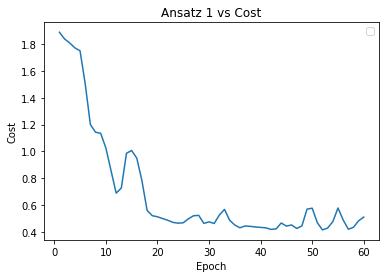

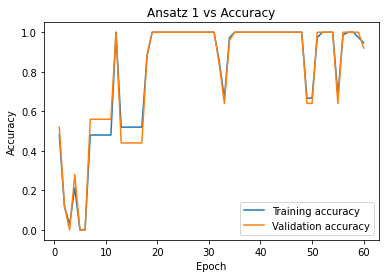

In [ ]:
plt.title("Ansatz 1 vs Cost")
plt.plot(epochsList, ansatz1Cost)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print()

plt.title("Ansatz 1 vs Accuracy")
plt.plot(epochsList, ansatz1TrainAccuracy, label = "Training accuracy")
plt.plot(epochsList, ansatz1ValAccuracy, label = "Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Ansatz 2

In [ ]:
def layer(W):
    qml.CNOT(wires=[0, 1])
    qml.CZ(wires=[0, 1])
    qml.CY(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CZ(wires=[1, 2])
    qml.CY(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CZ(wires=[2, 3])
    qml.CY(wires=[2, 3])
    qml.CNOT(wires=[3, 0])
    qml.CZ(wires=[3, 0])
    qml.CY(wires=[3, 0])

In [ ]:
# train the variational classifier
weights = weights_init
bias = bias_init

ansatz2Cost = []
ansatz2TrainAccuracy = []
ansatz2ValAccuracy = []

for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    circuit_cost = cost(weights, bias, features, Y)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, circuit_cost, acc_train, acc_val)
    )
    ansatz2Cost.append(circuit_cost)
    ansatz2TrainAccuracy.append(acc_train)
    ansatz2ValAccuracy.append(acc_val)

Iter:     1 | Cost: 1.9478279 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.8837298 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.8176283 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.7481325 | Acc train: 0.4800000 | Acc validation: 0.5200000 
Iter:     5 | Cost: 1.6938043 | Acc train: 0.4266667 | Acc validation: 0.4400000 
Iter:     6 | Cost: 1.6493672 | Acc train: 0.2000000 | Acc validation: 0.2400000 
Iter:     7 | Cost: 1.6229996 | Acc train: 0.0533333 | Acc validation: 0.0800000 
Iter:     8 | Cost: 1.6032752 | Acc train: 0.0133333 | Acc validation: 0.0000000 
Iter:     9 | Cost: 1.5954255 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:    10 | Cost: 1.5897453 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:    11 | Cost: 1.5873077 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:    12 | Cost: 1.5867696 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:    13 | Co

In [ ]:
print("Cost: ", ansatz2Cost)
print("Training accuracy: ", ansatz2TrainAccuracy)
print("Validation accuracy: ", ansatz2ValAccuracy)

Cost:  [tensor(1.94782786, requires_grad=True), tensor(1.88372984, requires_grad=True), tensor(1.81762829, requires_grad=True), tensor(1.74813255, requires_grad=True), tensor(1.69380429, requires_grad=True), tensor(1.64936725, requires_grad=True), tensor(1.62299959, requires_grad=True), tensor(1.60327517, requires_grad=True), tensor(1.59542553, requires_grad=True), tensor(1.58974526, requires_grad=True), tensor(1.58730773, requires_grad=True), tensor(1.5867696, requires_grad=True), tensor(1.58749769, requires_grad=True), tensor(1.58747961, requires_grad=True), tensor(1.58832917, requires_grad=True), tensor(1.58882885, requires_grad=True), tensor(1.59075172, requires_grad=True), tensor(1.59517604, requires_grad=True), tensor(1.5992211, requires_grad=True), tensor(1.60423202, requires_grad=True), tensor(1.60756182, requires_grad=True), tensor(1.6141974, requires_grad=True), tensor(1.61537117, requires_grad=True), tensor(1.61696133, requires_grad=True), tensor(1.61903843, requires_grad=Tr

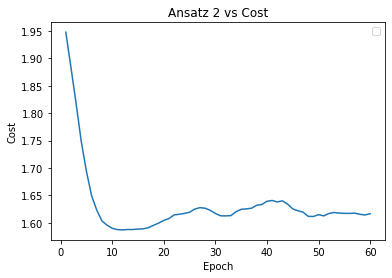

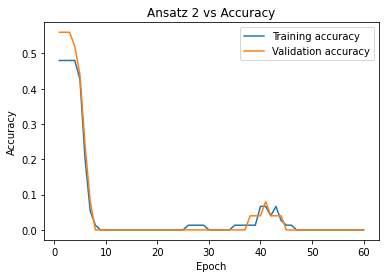

In [ ]:
plt.title("Ansatz 2 vs Cost")
plt.plot(epochsList, ansatz2Cost)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print()

plt.title("Ansatz 2 vs Accuracy")
plt.plot(epochsList, ansatz2TrainAccuracy, label = "Training accuracy")
plt.plot(epochsList, ansatz2ValAccuracy, label = "Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Ansatz 3

In [ ]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.PhaseShift(W[1, 0], wires=0)
    qml.PhaseShift(W[1, 1], wires=0)
    qml.PhaseShift(W[1, 2], wires=0)
    qml.RX(W[1, 0], wires=1)
    qml.PhaseShift(W[1, 2], wires=1)
    qml.RY(W[2, 0], wires=2)
    qml.PhaseShift(W[2, 2], wires=2)
    qml.RZ(W[3, 0], wires=3)
    qml.PhaseShift(W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)
        layer(W)
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# train the variational classifier
weights = weights_init
bias = bias_init

ansatz3Cost = []
ansatz3TrainAccuracy = []
ansatz3ValAccuracy = []

for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    circuit_cost = cost(weights, bias, features, Y)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, circuit_cost, acc_train, acc_val)
    )
    ansatz3Cost.append(circuit_cost)
    ansatz3TrainAccuracy.append(acc_train)
    ansatz3ValAccuracy.append(acc_val)

Iter:     1 | Cost: 1.6564416 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:     2 | Cost: 1.5115269 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.1433412 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.2312651 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:     5 | Cost: 1.5112900 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.3602889 | Acc train: 0.0933333 | Acc validation: 0.1200000 
Iter:     7 | Cost: 1.3349846 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 0.7176826 | Acc train: 0.9333333 | Acc validation: 0.9200000 
Iter:     9 | Cost: 1.1716118 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    10 | Cost: 1.4675620 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    11 | Cost: 2.2121921 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    12 | Cost: 2.4805609 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    13 | Co

In [ ]:
print("Cost: ", ansatz3Cost)
print("Training accuracy: ", ansatz3TrainAccuracy)
print("Validation accuracy: ", ansatz3ValAccuracy)

Cost:  [tensor(1.65644163, requires_grad=True), tensor(1.51152688, requires_grad=True), tensor(1.14334115, requires_grad=True), tensor(1.23126511, requires_grad=True), tensor(1.51129, requires_grad=True), tensor(1.3602889, requires_grad=True), tensor(1.33498463, requires_grad=True), tensor(0.71768262, requires_grad=True), tensor(1.17161179, requires_grad=True), tensor(1.46756197, requires_grad=True), tensor(2.21219207, requires_grad=True), tensor(2.48056089, requires_grad=True), tensor(0.88558273, requires_grad=True), tensor(1.02051144, requires_grad=True), tensor(1.18532836, requires_grad=True), tensor(1.15951612, requires_grad=True), tensor(1.97786848, requires_grad=True), tensor(1.85136795, requires_grad=True), tensor(0.84902587, requires_grad=True), tensor(1.02861516, requires_grad=True), tensor(1.33637194, requires_grad=True), tensor(1.52430643, requires_grad=True), tensor(1.57337745, requires_grad=True), tensor(1.50598428, requires_grad=True), tensor(1.11725185, requires_grad=Tru

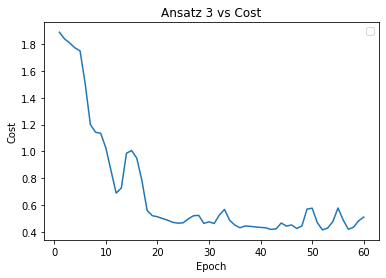

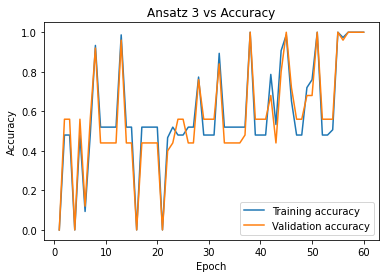

In [ ]:
plt.title("Ansatz 3 vs Cost")
plt.plot(epochsList, ansatz1Cost)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print()

plt.title("Ansatz 3 vs Accuracy")
plt.plot(epochsList, ansatz3TrainAccuracy, label = "Training accuracy")
plt.plot(epochsList, ansatz3ValAccuracy, label = "Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Final graphs for Ansatz section

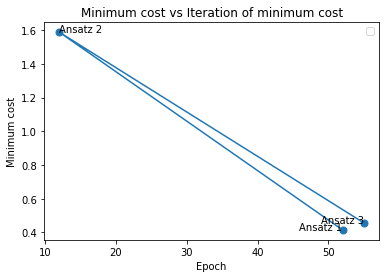

In [ ]:
secondCostGraphEpoch = []
secondCostGraphValue = []

epochAnsatz1Index = 0
for index, tensorVal in enumerate(ansatz1Cost):
  if tensorVal == min(ansatz1Cost):
    epochAnsatz1Index = index + 1
    break
secondCostGraphEpoch.append(epochAnsatz1Index)
secondCostGraphValue.append(min(ansatz1Cost))

epochAnsatz2Index = 0
for index, tensorVal in enumerate(ansatz2Cost):
  if tensorVal == min(ansatz2Cost):
    epochAnsatz2Index = index + 1
    break
secondCostGraphEpoch.append(epochAnsatz2Index)
secondCostGraphValue.append(min(ansatz2Cost))

epochAnsatz3Index = 0
for index, tensorVal in enumerate(ansatz3Cost):
  if tensorVal == min(ansatz3Cost):
    epochAnsatz3Index = index + 1
    break
secondCostGraphEpoch.append(epochAnsatz3Index)
secondCostGraphValue.append(min(ansatz3Cost))

plt.title('Minimum cost vs Iteration of minimum cost')
plt.plot(secondCostGraphEpoch, secondCostGraphValue, marker='.', markersize=14)
plt.ylabel('Minimum cost')
plt.xlabel('Epoch')
plt.text(secondCostGraphEpoch[0], secondCostGraphValue[0],'Ansatz 1', horizontalalignment='right')
plt.text(secondCostGraphEpoch[1], secondCostGraphValue[1],'Ansatz 2')
plt.text(secondCostGraphEpoch[2], secondCostGraphValue[2], 'Ansatz 3', horizontalalignment='right')
plt.legend()
plt.show()

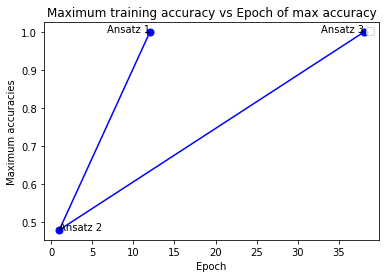

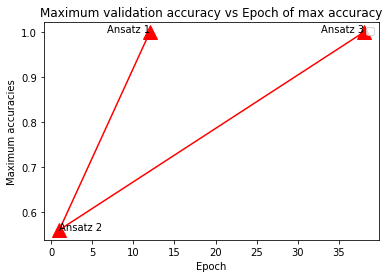

In [7]:
secondTrainingGraphEpoch = []
secondTrainingGraphValue = []
secondValGraphEpoch = []
secondValGraphValue = []

# Ansatz 1
epochAnsatz1Index = 0
for index, tensorVal in enumerate(ansatz1TrainAccuracy):
  if tensorVal == max(ansatz1TrainAccuracy):
    epochAnsatz1Index = index + 1
    break
secondTrainingGraphEpoch.append(epochAnsatz1Index)
secondTrainingGraphValue.append(max(ansatz1TrainAccuracy))

valueAnsatz1Index = 0
for index, tensorVal in enumerate(ansatz1ValAccuracy):
  if tensorVal == max(ansatz1ValAccuracy):
    valueAnsatz1Index = index + 1
    break
secondValGraphEpoch.append(valueAnsatz1Index)
secondValGraphValue.append(max(ansatz1ValAccuracy))

# Ansatz 2
epochAnsatz2Index = 0
for index, tensorVal in enumerate(ansatz2TrainAccuracy):
  if tensorVal == max(ansatz2TrainAccuracy):
    epochAnsatz2Index = index + 1
    break
secondTrainingGraphEpoch.append(epochAnsatz2Index)
secondTrainingGraphValue.append(max(ansatz2TrainAccuracy))

valueAnsatz2Index = 0
for index, tensorVal in enumerate(ansatz2ValAccuracy):
  if tensorVal == max(ansatz2ValAccuracy):
    valueAnsatz2Index = index + 1
    break
secondValGraphEpoch.append(valueAnsatz2Index)
secondValGraphValue.append(max(ansatz2ValAccuracy))

# Ansatz 3
epochAnsatz3Index = 0
for index, tensorVal in enumerate(ansatz3TrainAccuracy):
  if tensorVal == max(ansatz3TrainAccuracy):
    epochAnsatz3Index = index + 1
    break
secondTrainingGraphEpoch.append(epochAnsatz3Index)
secondTrainingGraphValue.append(max(ansatz3TrainAccuracy))

valueAnsatz3Index = 0
for index, tensorVal in enumerate(ansatz3ValAccuracy):
  if tensorVal == max(ansatz3ValAccuracy):
    valueAnsatz3Index = index + 1
    break
secondValGraphEpoch.append(valueAnsatz3Index)
secondValGraphValue.append(max(ansatz3ValAccuracy))

# print(secondTrainingGraphEpoch, secondTrainingGraphValue)
# print(firstValGraphEpoch, firstValGraphValue)

plt.title('Maximum training accuracy vs Epoch of max accuracy')
plt.plot(secondTrainingGraphEpoch, secondTrainingGraphValue, c='b', marker='.', markersize=14)
plt.ylabel('Maximum accuracies')
plt.xlabel('Epoch')
plt.text(secondTrainingGraphEpoch[0],secondTrainingGraphValue[0],'Ansatz 1',horizontalalignment='right')
plt.text(secondTrainingGraphEpoch[1],secondTrainingGraphValue[1],'Ansatz 2')
plt.text(secondTrainingGraphEpoch[2],secondTrainingGraphValue[2],'Ansatz 3',horizontalalignment='right')
# plt.text(secondTrainingGraphEpoch[3],secondTrainingGraphValue[3],'Rotation(Rz)',horizontalalignment='right')
plt.legend()
plt.show()
print()

plt.title('Maximum validation accuracy vs Epoch of max accuracy')
plt.plot(secondValGraphEpoch, secondValGraphValue, c='r', marker='^', markersize=14)
plt.ylabel('Maximum accuracies')
plt.xlabel('Epoch')
plt.text(secondValGraphEpoch[0],secondValGraphValue[0],'Ansatz 1',horizontalalignment='right')
plt.text(secondValGraphEpoch[1],secondValGraphValue[1],'Ansatz 2')
plt.text(secondValGraphEpoch[2],secondValGraphValue[2],'Ansatz 3',horizontalalignment='right')
# plt.text(secondValGraphEpoch[3],secondValGraphValue[3],'Rotation(Rz)')
plt.legend()
plt.show()